## Importing Libraries

In [1]:
import cv2
import re
#import pytesseract
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from tensorflow import keras
import keras_ocr
from matplotlib import pyplot as pltd 
from math import dist
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

## Defining several functions

### 1) Plot image

In [2]:
def show_image(img, title_str):
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap='gray')
    plt.title(title_str, fontsize = 16, fontweight = 'bold')

### 2) Object Detection

In [3]:
def object_detection(c_img, gray_img):
    
    color_img = c_img.copy()
    # setting threshold of gray_img_1 image
    _, threshold = cv2.threshold(gray_img, 240, 255, cv2.THRESH_BINARY)
      
    # using a findContours() function
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rectangle, triangle = [], []      
    i = 0
      
    # list for storing names of shapes
    for contour in contours:
      
        # here we are ignoring first counter because 
        # findcontour function detects whole image as shape
        if i == 0:
            i = 1
            continue
      
        # cv2.approxPloyDP() function to approximate the shape
        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        x_cor = approx.ravel()[0]
        y_cor = approx.ravel()[1]
      
        # putting shape name at center of each shape
        if len(approx) == 4:
            rectangle.append(contour)
            x,y,w,h = cv2.boundingRect(approx)
            
            #width:height
            aspectRatio = float(w)/h
            cv2.drawContours(color_img, [approx], 0, (0,255,0), 4)
            
            #if aspectRatio < 0.9 and aspectRatio >1.1:
                #cv2.putText(img1, "Rectangle", (x_cor, y_cor), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0))
            #For triangle
            
        if len(approx) == 3:
            triangle.append(contour)
            cv2.drawContours(color_img, [approx], 0, (0,255,0), 2)
            #cv2.putText(img1, "Triangle", (x_cor, y_cor), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
            
    #displaying the image after drawing contours
    show_image(color_img, 'Contour Image')
    
    return rectangle, triangle

### 3) Reading the legend from the plot image

In [4]:
def get_legend(color_image):
    
    img = color_image.copy()
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    rect, _ = object_detection(color_image, gray_image)
    loc_of_legend = []
    
    for i in rect:
        try:
            i = i.reshape([4,2])
        except:
            i = i.reshape([i.shape[0], i.shape[2]])
            loc_of_legend.append(i)
    
    max_x = np.max(loc_of_legend[0], axis = 0)
    min_x = np.min(loc_of_legend[0], axis = 0)
    
    legend_image = color_image[min_x[1]:max_x[1], min_x[0]+5:max_x[0]-5].copy()
    color_image[min_x[1]-2:max_x[1]+2, min_x[0]-2:max_x[0]+2] = 255
    
    # Smoothing the legend colors
    smoothed_img = []
    
    for i in range(legend_image.shape[0]):
        p_val = np.median(legend_image[i], axis = 0)
        p_val[0] = int(p_val[0])
        p_val[1] = int(p_val[1])
        p_val[2] = int(p_val[2])
        
        row = [p_val,]*legend_image.shape[1]
        smoothed_img.append(row)
        
    smoothed_img = np.array(smoothed_img, dtype = 'uint8')

    return img, color_image, smoothed_img 

### 4) Counting edges in legend

In [5]:
def edges_in_legend(legend_img):
    
    edge_img = cv2.Canny(legend_img, 45, 30)
    show_image(edge_img, 'Edge Image')
    
    if edge_img.shape[0] > edge_img.shape[1]:
        pos = int(edge_img.shape[1]/2)        
        
    elif edge_img.shape[0] < edge_img.shape[1]:
        pos = int(edge_img.shape[0]/2)       
        
    edge_pixel_loc = []
    dist_list = []
        
    prev, mean_val, c = 0, 0, 1
    for i in range(edge_img.shape[0]):
        
        if edge_img.shape[0] > edge_img.shape[1]:
            ind = [i, pos]
            
        elif edge_img.shape[0] < edge_img.shape[1]:
            ind = [pos, i]
        
        pixel_val = edge_img[ind[0], ind[1]]
        
        if pixel_val == 255:
            edge_pixel_loc.append(i)
            
            #dist = i-prev
            #mean_val = i/c       
            #
            #if dist >= 0.75*mean_val:
            #    edge_pixel_loc.append(i)
            #    dist_list.append(dist)
            #    prev = i
            #else:
            #    edge_pixel_loc.remove(prev)                
            #    prev = int((i+prev)*0.5)
            #    edge_pixel_loc.append(prev)
            #
            #c+=1
    
    # completing incomplete detected edge array
    running_diff = []
    for i in range(1, len(edge_pixel_loc)):
        diff = edge_pixel_loc[i] - edge_pixel_loc[i-1]
        running_diff.append(diff)            
        
    thresh = Counter(running_diff).most_common()[0][0]
    corrected_edge = [edge_pixel_loc[0]]
    c = 1
    d = 0
    
    while corrected_edge[d] < edge_pixel_loc[-1]:
        
        diff = edge_pixel_loc[c] - corrected_edge[d]
        
        if diff<thresh-2 or diff>thresh+2:
            corrected_edge.append(corrected_edge[d] + thresh)            
        else:
            corrected_edge.append(edge_pixel_loc[c])
            c+=1        
        d+=1
            
    return corrected_edge

### 5) Smoothing color gradients in legend row-wise

In [6]:
#def smoothing_legend(legend_img):
#    img = []
#    
#    for i in range(legend_img.shape[0]):
#        p_val = np.mean(legend_img[i], axis = 0)
#        p_val[0] = int(p_val[0])
#        p_val[1] = int(p_val[1])
#        p_val[2] = int(p_val[2])
#        
#        row = [p_val,]*legend_img.shape[1]
#        img.append(row)
#        
#    img = np.array(img, dtype = 'uint8')
#    return img

### 6) Reading colors in the legend

In [7]:
def colors_in_legend(legend_img, loc_edge_pixel):
    color_gradients = []
    prev = loc_edge_pixel[0]
    
    for i in loc_edge_pixel[1:]:
        a = legend_img[prev+1:i-1, 0]
        a = np.median(a, axis=0)
        a = np.array(a, dtype='uint8')
        color_gradients.append(tuple(a))
        prev = i
    
    return color_gradients

## Reading plot image

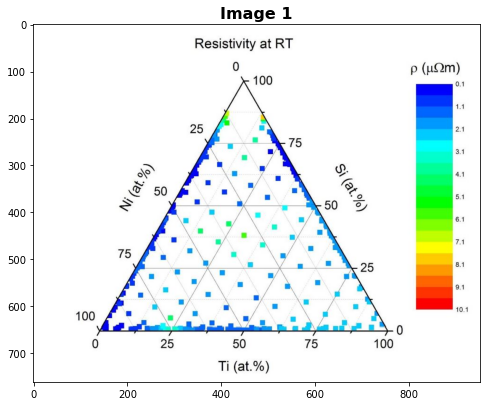

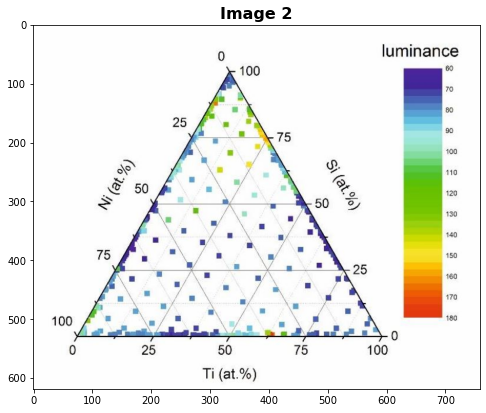

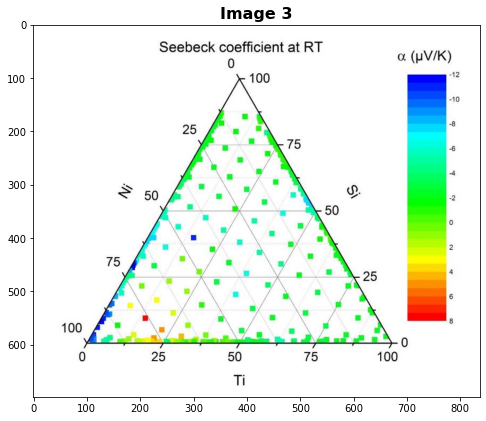

In [8]:
img1 = cv2.imread('ternary_plot_1.jpg')
img2 = cv2.imread('ternary_plot_2.jpg')
img3 = cv2.imread('ternary_plot_3.jpg')
#img1 = img1[:,:,[2,1,0]] #BGR to RGB conversion

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB) 

gray_img_1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray_img_2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray_img_3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

show_image(img1, 'Image 1')
show_image(img2, 'Image 2')
show_image(img3, 'Image 3')

## Object Detection

### 1) For Image 1

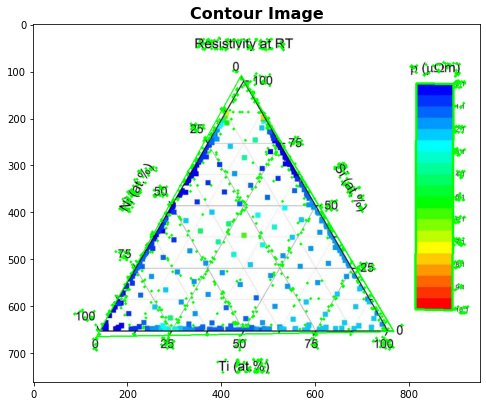

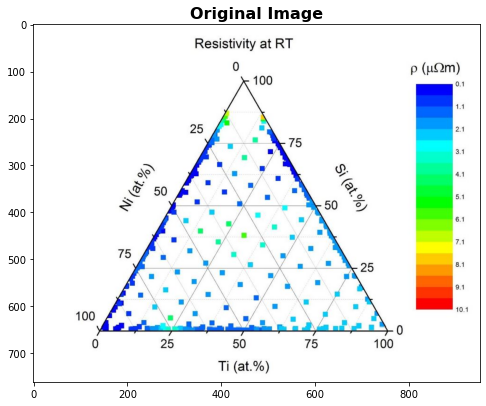

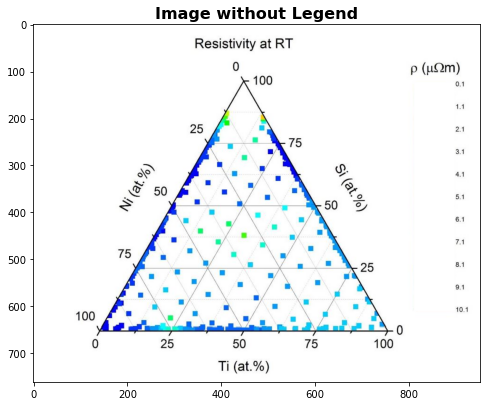

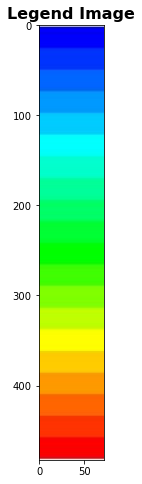

In [9]:
img1, img_without_legend_1, legend_img_1 = get_legend(img1)
show_image(img1, 'Original Image')
show_image(img_without_legend_1, 'Image without Legend')
show_image(legend_img_1, 'Legend Image')

21

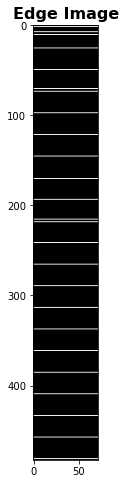

In [10]:
#legend_img_1 = smoothing_legend(legend_img_1)
num_colors_in_legend_1 = edges_in_legend(legend_img_1)
len(num_colors_in_legend_1)

### 2) For Image 2

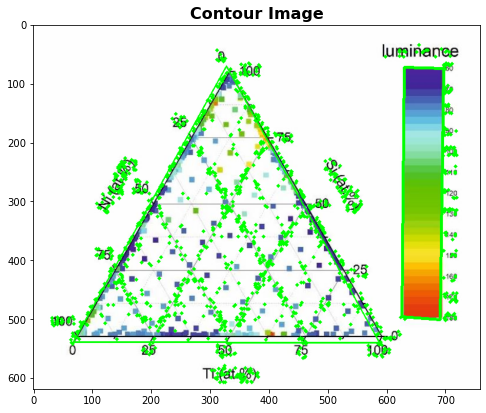

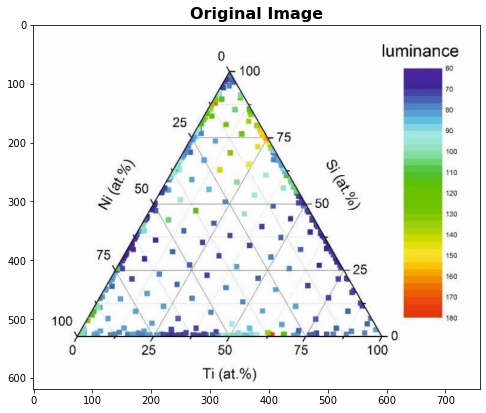

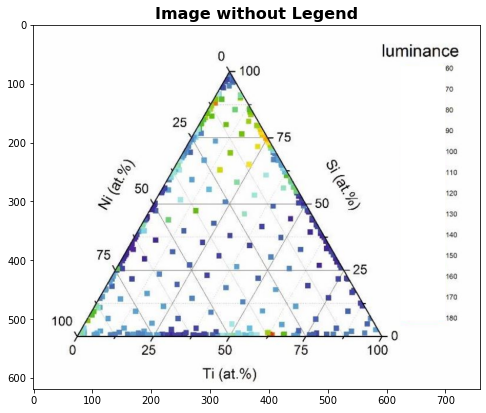

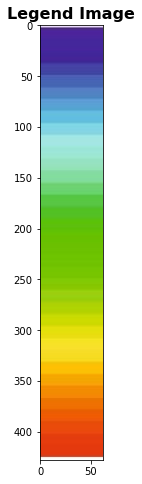

In [11]:
img2, img_without_legend_2, legend_img_2 = get_legend(img2)
show_image(img2, 'Original Image')
show_image(img_without_legend_2, 'Image without Legend')
show_image(legend_img_2, 'Legend Image')

39

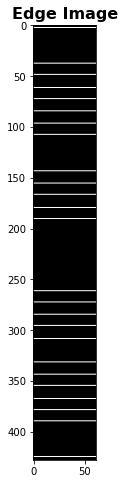

In [12]:
#legend_img_2 = smoothing_legend(legend_img_2)
num_colors_in_legend_2 = edges_in_legend(legend_img_2)
len(num_colors_in_legend_2)

### 3) For Image 3

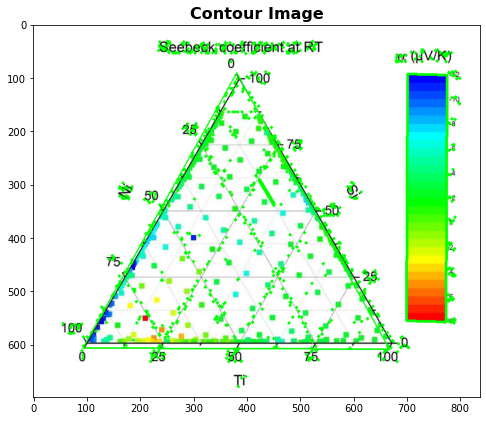

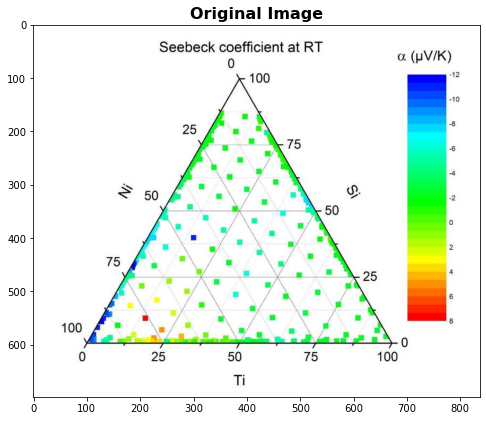

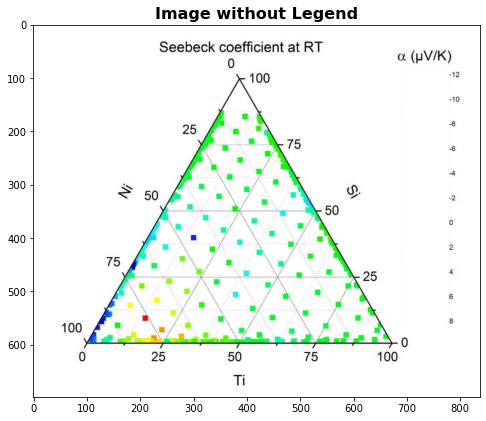

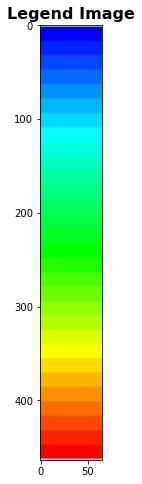

In [13]:
img3, img_without_legend_3, legend_img_3 = get_legend(img3)
show_image(img3, 'Original Image')
show_image(img_without_legend_3, 'Image without Legend')
show_image(legend_img_3, 'Legend Image')

31

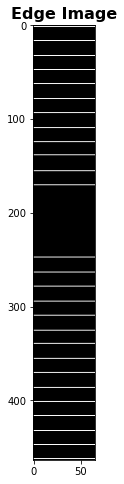

In [14]:
#legend_img_3 = smoothing_legend(legend_img_3)
num_colors_in_legend_3 = edges_in_legend(legend_img_3)
len(num_colors_in_legend_3)

In [15]:
legend_colors = colors_in_legend(legend_img_1, num_colors_in_legend_1)
legend_colors

[(1, 1, 252),
 (0, 51, 252),
 (1, 101, 255),
 (0, 153, 254),
 (1, 203, 254),
 (1, 255, 254),
 (2, 254, 205),
 (0, 254, 153),
 (0, 254, 103),
 (0, 254, 52),
 (0, 255, 1),
 (62, 254, 2),
 (127, 255, 0),
 (190, 255, 1),
 (255, 255, 1),
 (254, 204, 0),
 (253, 153, 0),
 (255, 101, 1),
 (255, 51, 1),
 (252, 1, 0)]

## Steps for extraction of value of the inner square.

- User input required:-
    - Ask for min and max values for triangle and legend.
    - Ask for selecting the vertices of the triangle.
    - Ask for selecting one independent inner shape.

- We need to first identify pt1, pt2, pt3, selected by the user.
    - pt1 is always the top one.
    - pt2 is always the bottom left.
    - pt3 is always the bottom right.
    
- Then considering any one side (the left edge) we need to find the maximum value for that side (usually 100). The maximum value for one side will also be for the others.
    - pt1 is the min value for left edge.
    - pt3 is the min value for right edge.
    - pt2 is the min value for bottom edge.
    
- For a particular inner square selected by the user we need to draw 3 lines at (60, -60, 0). And check where these 3 lines intersect the corresponding edges and take the dist from 0 of that edge and then return the value.

### Step-1: Identify pt1, pt2 & pt3

In [16]:
#these are selected by the user in any order.
a = (653, 753)
b = (122, 449)
c = (652, 144)

In [17]:
def get_points(a, b, c):
    x_pts = [a[1], b[1], c[1]]
    y_pts = [a[0], b[0], c[0]]
    
    for i in range(3):
        x = x_pts[i]
        y = y_pts[i]
        
        if y == min(y_pts):
            pt1 = (x, img1.shape[0]-y)
        
        if x == min(x_pts):
            pt2 = (x, img1.shape[0]-y)
            
        if x == max(x_pts):
            pt3 = (x, img1.shape[0]-y)
    
    return pt1, pt2, pt3

# remember that pt1 is min val for left edge.
# remember that pt2 is min val for bottom edge.
# remember that pt3 is min val for right edge.

#x_pts = [a[1], b[1], c[1]]
#y_pts = [a[0], b[0], c[0]]
#
#for i in range(3):
#    x = x_pts[i]
#    y = y_pts[i]
#    
#    if y == min(y_pts):
#        pt1 = (x, y)
#    
#    if x == min(x_pts):
#        pt2 = (x, y)
#        
#    if x == max(x_pts):
#        pt3 = (x, y)
#
#print(pt1, pt2, pt3)

# remember that pt1 is min val for left edge.
# remember that pt2 is min val for bottom edge.
# remember that pt3 is min val for right edge.

In [18]:
pt1, pt2, pt3 = get_points(a, b, c)

### Step-2: Finding slopes for each line.

In [19]:
def get_slopes(pt1, pt2, pt3):
    slope_1 = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])   # It is always the left edge of the triangle
    slope_2 = (pt3[1] - pt1[1])/(pt3[0] - pt1[0])   # It is always the right edge of the triangle
    slope_3 = (pt2[1] - pt3[1])/(pt2[0] - pt3[0])   # It is always the bottom edge of the triangle
    
    theta_1 = math.atan(slope_1)*180/math.pi#tan theta 
    theta_2 = math.atan(slope_2)*180/math.pi
    theta_3 = math.atan(slope_3)*180/math.pi
    
    print('Slope for left edge: ', int(theta_1), 
          '\nSlope for right edge: ', int(theta_2), 
          '\nSlope for bottom edge: ', int(theta_3))
    
    return slope_1, slope_2, slope_3

# Just remember that m_line_1 is reference slope for getting intersection pt on the right edge.
# Just remember that m_line_2 is reference slope for getting intersection pt on the bottom edge.
# Just remember that m_line_3 is reference slope for getting intersection pt on the left edge.

#m_line_1 = math.atan((pt1[1]-pt2[1])/(pt2[0]-pt1[0]))   # It is always the left edge of the triangle
#m_line_2 = math.atan((pt1[1]-pt3[1])/(pt3[0]-pt1[0]))   # It is always the right edge of the triangle
#m_line_3 = math.atan((pt3[1]-pt2[1])/(pt2[0]-pt3[0]))   # It is always the bottom edge of the triangle
#
#theta_1 = m_line_1*180/math.pi
#theta_2 = m_line_2*180/math.pi
#theta_3 = m_line_3*180/math.pi
#
#print(int(theta_1), int(theta_2), int(theta_3))

# Just remember that m_line_1 is reference slope for getting intersection pt on the right edge.
# Just remember that m_line_2 is reference slope for getting intersection pt on the bottom edge.
# Just remember that m_line_3 is reference slope for getting intersection pt on the left edge.

In [20]:
m_line_1, m_line_2, m_line_3 = get_slopes(pt1, pt2, pt3)

Slope for left edge:  60 
Slope for right edge:  -60 
Slope for bottom edge:  0


### Step-3: Considering a sample point

In [21]:
# Consider the blue pt at (297,397) as selected by the user and flip it.
sample_pt = (297, 397)
sample_pt_color = img1[297, 397]
print(sample_pt_color)

sample_pt = (sample_pt[1], 762 - sample_pt[0])
print(sample_pt)

[  2  51 255]
(397, 465)


### Step-4: Fetching all the 3 values for that point

In [22]:
def get_value_for_point(pt1, pt2, pt3, slope_1, slope_2, slope_3, d):

    # Checking the value for left edge.
    #y_left = slope_1*x_left - slope_1*pt1[0] + pt1[1]  # eqn for left edge
    #y = slope_3*x - slope_3*d[0] + d[1]  # eqn of horizontal line passing through selected point.
    
    x_left = (slope_3*d[0] - d[1] - slope_1*pt1[0] + pt1[1]) / (slope_3 - slope_1)
    y_left = slope_3*x_left - slope_3*d[0] + d[1]
    
    intersect_pt_on_left = (int(x_left), int(y_left))
    
    left_intersect_dist = math.dist(intersect_pt_on_left, pt1)
    left_edge_length = math.dist(pt2, pt1)
    left_val = left_intersect_dist*100/left_edge_length
    left_val
    
    # Checking the value for right edge.
    #y_right = slope_2*x_right - slope_2*pt3[0] + pt3[1]  # eqn for right edge
    #y = slope_1*x - slope_1*d[0] + d[1]  # eqn of right slanted line passing through selected point.
    
    x_right = (slope_1*d[0] - d[1] - slope_2*pt3[0] + pt3[1]) / (slope_1 - slope_2)
    y_right = slope_1*x_right - slope_1*d[0] + d[1]
    
    intersect_pt_on_right = (int(x_right), int(y_right))
    
    right_intersect_dist = math.dist(intersect_pt_on_right, pt3)
    right_edge_length = math.dist(pt3, pt1)
    right_val = right_intersect_dist*100/right_edge_length
    right_val
    
    # Checking the value for bottom edge.
    #y_bottom = slope_3*x_bottom - slope_3*pt2[0] + pt2[1]  # eqn of bottom edge
    #y = slope_2*x - slope_2*d[0] + d[1]   # eqn for left slanted line passing through selected point
    
    x_bottom = (slope_2*d[0] - d[1] - slope_3*pt2[0] + pt2[1]) / (slope_2 - slope_3)
    y_bottom = slope_2*x_bottom - slope_2*d[0] + d[1]
    
    intersect_pt_on_bottom = (int(x_bottom), int(y_bottom))
    
    bottom_intersect_dist = math.dist(intersect_pt_on_bottom, pt2)
    bottom_edge_length = math.dist(pt3, pt2)
    bottom_val = bottom_intersect_dist*100/bottom_edge_length
    bottom_val
    
    return np.round(left_val, 2), np.round(right_val, 2), np.round(bottom_val, 2)

In [23]:
a, b, c = get_value_for_point(pt1, pt2, pt3, m_line_1, m_line_2, m_line_3, sample_pt)
print('Left Edge value for the sample pt. is: ', a, '%', 
      '\nRight Edge value for the sample pt. is: ', b, '%', 
      '\nBottom Edge value for the sample pt. is: ', c, '%')

Left Edge value for the sample pt. is:  33.04 % 
Right Edge value for the sample pt. is:  91.95 % 
Bottom Edge value for the sample pt. is:  74.88 %


In [24]:
di = []
for i in legend_colors:
    di.append(math.dist(i, sample_pt_color))
    
ind = list(np.argsort(di))[0]
print('Actual Color of the pt:', sample_pt_color)
print('Color of sample pt: ', legend_colors[ind])

Actual Color of the pt: [  2  51 255]
Color of sample pt:  (0, 51, 252)


### Results for smoothing with mean

In [25]:
# There's no need to find edges in the legend
sample_legend_img = legend_img_1[min(num_colors_in_legend_1):max(num_colors_in_legend_1), 35]
di = []

for i in list(sample_legend_img):
    di.append(math.dist(i, sample_pt_color))
    
sample_pt_color_ind = list(np.argsort(di))[0]
print('Actual Color of the pt:', sample_pt_color)
print('Color of sample pt: ', list(sample_legend_img)[sample_pt_color_ind])

legend_max_val = 10.1
legend_min_val = 0.1

val_of_each_pixel = (legend_max_val - legend_min_val)/sample_legend_img.shape[0]

# If min val of legend is at the top
actual_val_of_pt = np.round(sample_pt_color_ind * val_of_each_pixel + legend_min_val, 2)
print('Value for the selected point is: ', actual_val_of_pt)

Actual Color of the pt: [  2  51 255]
Color of sample pt:  [  1  50 253]
Value of the selected point is:  0.75


### Results for smoothing with median

In [25]:
# There's no need to find edges in the legend
sample_legend_img = legend_img_1[min(num_colors_in_legend_1):max(num_colors_in_legend_1), 35]
di = []

for i in list(sample_legend_img):
    di.append(math.dist(i, sample_pt_color))
    
sample_pt_color_ind = list(np.argsort(di))[0]
print('Actual Color of the pt:', sample_pt_color)
print('Color of sample pt: ', list(sample_legend_img)[sample_pt_color_ind])

legend_max_val = 10.1
legend_min_val = 0.1

val_of_each_pixel = (legend_max_val - legend_min_val)/sample_legend_img.shape[0]

# If min val of legend is at the top
actual_val_of_pt = np.round(sample_pt_color_ind * val_of_each_pixel + legend_min_val, 2)
print('Value for the selected point is: ', actual_val_of_pt)

Actual Color of the pt: [  2  51 255]
Color of sample pt:  [  2  50 254]
Value of the selected point is:  0.75


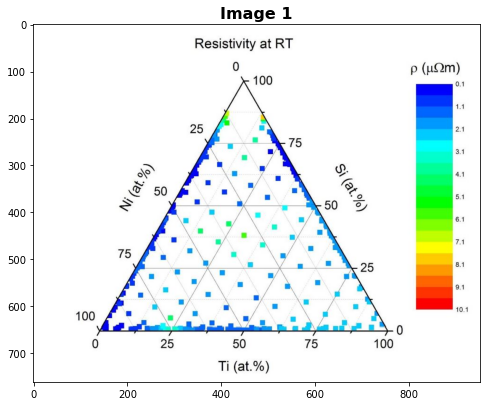

In [27]:
show_image(img1, 'Image 1')

## Reading text in plot image using Keras-OCR

In [28]:
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read(url) for url in [r'C:\Users\Admin\Documents\Ternary Plot\ternary_plot_1.jpg', 
                                                r'C:\Users\Admin\Documents\Ternary Plot\ternary_plot_2.jpg']]#, 
                                                #r'C:\Users\Admin\Documents\Ternary Plot\ternary_plot_3.jpg']]

Looking for C:\Users\Admin\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Admin\.keras-ocr\crnn_kurapan.h5


In [29]:
# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

3/3 [==============================] - 12s 3s/step


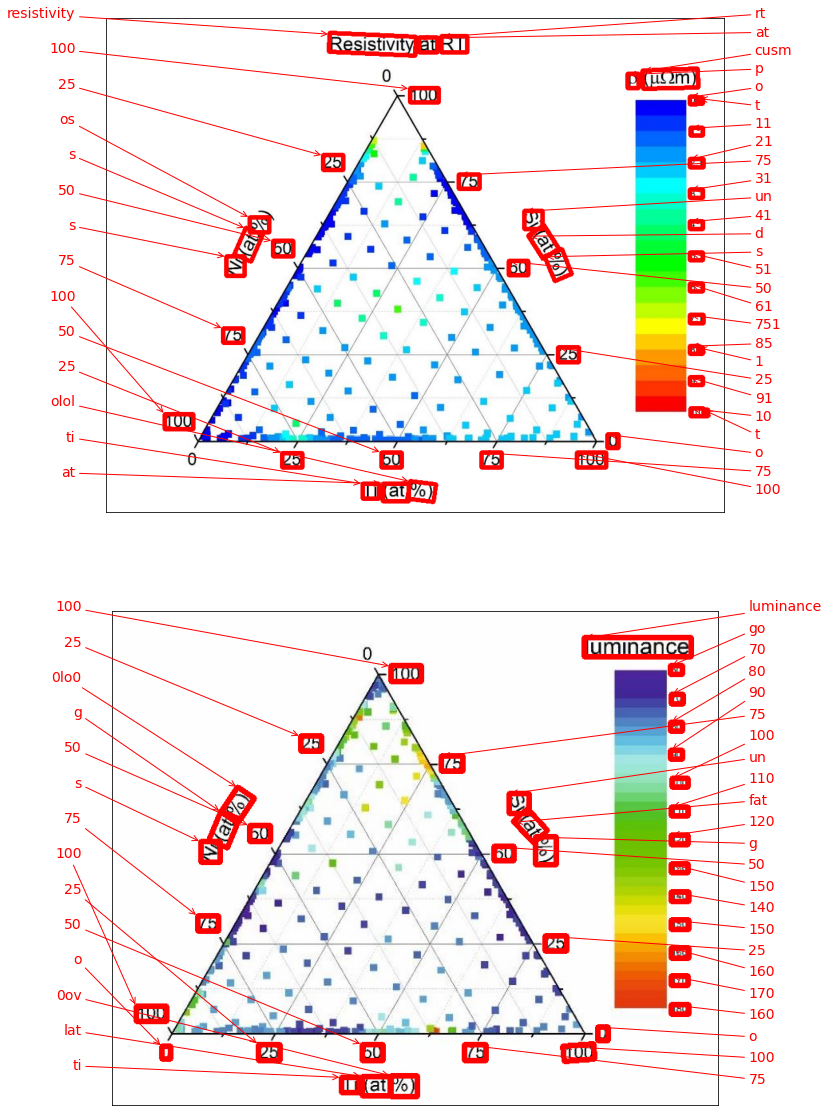

In [30]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [31]:
pred_img1 = prediction_groups[0]
temp = []

for i in pred_img1:
    if len(re.sub(r'[0-9]', '', i[0])) == 0:
        temp.append(i)

temp

[('100',
  array([[468., 109.],
         [512., 109.],
         [512., 131.],
         [468., 131.]], dtype=float32)),
 ('11',
  array([[900., 170.],
         [919., 170.],
         [919., 182.],
         [900., 182.]], dtype=float32)),
 ('25',
  array([[334., 212.],
         [365., 212.],
         [365., 235.],
         [334., 235.]], dtype=float32)),
 ('21',
  array([[899., 218.],
         [920., 218.],
         [920., 231.],
         [899., 231.]], dtype=float32)),
 ('75',
  array([[543., 242.],
         [575., 242.],
         [575., 264.],
         [543., 264.]], dtype=float32)),
 ('31',
  array([[899., 265.],
         [919., 265.],
         [919., 278.],
         [899., 278.]], dtype=float32)),
 ('41',
  array([[899., 314.],
         [919., 314.],
         [919., 326.],
         [899., 326.]], dtype=float32)),
 ('50',
  array([[257., 344.],
         [288., 344.],
         [288., 368.],
         [257., 368.]], dtype=float32)),
 ('51',
  array([[899., 362.],
         [919., 362.],
 

In [32]:
def points_near_to_line(pt1, pt2, pred_grp):
    x1 = pt1[0]; x2 = pt2[0]
    y1 = pt1[1]; y2 = pt2[1]
    
    m = (y1-y2)/(x1-x2)
    theta = int(math.atan(m)*180/3.14)
    list_of_points = []
    
    for i in pred_grp:  
        x = i[1][0][0]
        y = 762 - i[1][0][1]
        a = m*x - y 
        b = m*x1 - y1
        
        if a < b:
            list_of_points.append(i)

    return list_of_points

In [33]:
Ni_ticks = points_near_to_line(pt2, pt1, temp)
Ni_ticks

[('25',
  array([[334., 212.],
         [365., 212.],
         [365., 235.],
         [334., 235.]], dtype=float32)),
 ('50',
  array([[257., 344.],
         [288., 344.],
         [288., 368.],
         [257., 368.]], dtype=float32)),
 ('75',
  array([[180., 479.],
         [211., 479.],
         [211., 501.],
         [180., 501.]], dtype=float32)),
 ('100',
  array([[ 90., 611.],
         [134., 611.],
         [134., 634.],
         [ 90., 634.]], dtype=float32))]

### Left Edge

In [34]:
## Checking the value for left edge.
##y_left = m_line_1*x_left - m_line_1*pt1[0] + pt1[1]  # eqn for left edge
##y = m_line_3*x - m_line_3*d[0] + d[1]  # eqn of horizontal line passing through selected point.
#
#x_left = (m_line_3*d[0] - d[1] - m_line_1*pt1[0] + pt1[1]) / (m_line_3 - m_line_1)
#y_left = m_line_3*x_left - m_line_3*d[0] + d[1]
#
#intersect_pt = (int(x_left), int(y_left))
#
#print(intersect_pt)
#
#int_di = math.dist(intersect_pt, pt1)
#t_di = math.dist(pt2, pt1)
#unit = t_di/100
#left_val = int_di/unit
#left_val

### Right Edge

In [35]:
## Checking the value for right edge.
##y_right = m_line_2*x_right - m_line_2*pt3[0] + pt3[1]  # eqn for right edge
##y = m_line_1*x - m_line_1*d[0] + d[1]  # eqn of right slanted line passing through selected point.
#
#x_right = (m_line_1*d[0] - d[1] - m_line_2*pt3[0] + pt3[1]) / (m_line_1 - m_line_2)
#y_right = m_line_1*x_right - m_line_1*d[0] + d[1]
#
#intersect_pt = (int(x_right), int(y_right))
#
#print(intersect_pt)
#
#int_di = math.dist(intersect_pt, pt3)
#t_di = math.dist(pt3, pt1)
#unit = t_di/100
#left_val = int_di/unit
#left_val

### Bottom Edge

In [36]:
## Checking the value for bottom edge.
##y_bottom = m_line_3*x_bottom - m_line_3*pt2[0] + pt2[1]  # eqn of bottom edge
##y = m_line_2*x - m_line_2*d[0] + d[1]   # eqn for left slanted line passing through selected point
#
#x_bottom = (m_line_2*d[0] - d[1] - m_line_3*pt2[0] + pt2[1]) / (m_line_2 - m_line_3)
#y_bottom = m_line_2*x_bottom - m_line_2*d[0] + d[1]
#
#intersect_pt = (int(x_bottom), int(y_bottom))
#
#print(intersect_pt)
#
#int_di = math.dist(intersect_pt, pt2)
#t_di = math.dist(pt3, pt2)
#unit = t_di/100
#left_val = int_di/unit
#left_val